# `rcal.alternate` overview

In [1]:
import rcal.alternate as rcal
from pprint import pprint

Here we show a very simple example of using `rcal.alternate`. This notebook is almost exactly the same as [this notebook](https://github.com/jtiosue/rcal/blob/main/examples/rcal-overview.ipynb), except that it uses the `rcal.alternate` module instead of the `rcal` module. You'll see that the results are essentially identical.

Suppose for example that we have the following ratings.

In [2]:
data = {
    ('r1', 'p0', 0): 1,  # reviewer 1 gives person 0 a 1 star rating on day 0
    ('r1', 'p1', 1): 3,  # reviewer 1 gives person 1 a 3 star rating on day 1
    ('r1', 'p2', 2): 3,  # reviewer 1 gives person 2 a 3 star rating on day 2

    ('r2', 'p2', 0): 3,  # reviewer 2 gives person 2 a 3 star rating on day 0
    ('r2', 'p0', 1): 3,  # reviewer 2 gives person 0 a 3 star rating on day 1
    ('r2', 'p1', 2): 4,  # reviewer 2 gives person 1 a 4 star rating on day 2

    ('r3', 'p1', 0): 2,  # reviewer 3 gives person 1 a 2 star rating on day 0
    ('r3', 'p2', 1): 2,  # reviewer 3 gives person 2 a 2 star rating on day 1
    ('r3', 'p0', 2): 3,  # reviewer 3 gives person 0 a 3 star rating on day 2

    ('r1', 'p3', 0): 1,  # reviewer 1 gives person 3 a 1 star rating on day 0
    ('r2', 'p3', 1): 1,  # reviewer 2 gives person 3 a 1 star rating on day 1
    ('r3', 'p3', 2): 1,  # reviewer 3 gives person 3 a 1 star rating on day 2

    ('r1', 'p4', 0): 5   # reviewer 1 gives person 4 a 5 star rating on day 0
}

## Calibrating the parameters

We now calibrate. Calibrating returns a `rcal.CalibrationParameters` object that encodes the information about the calibration.

In [3]:
cp = rcal.calibrate_parameters(data)

We now want to rescale the parameters such that the resulting calibrated data lies between 1 and 5 stars. (Note that `rescale_parameters` updates the object `cp` in place, but also returns `self` which is why you see a returned object after this cell)

In [4]:
cp.rescale_parameters(data, bounds=(1, 5))

With the `rcal.CalibrationParameters` object, we can use the parameters that were learned from the calibration procedure to calibrate the data.

In [5]:
pprint(cp.calibrate_data(data))

{('r1', 'p0', 0): 1.0,
 ('r1', 'p1', 1): 3.0,
 ('r1', 'p2', 2): 3.0,
 ('r1', 'p3', 0): 1.0,
 ('r1', 'p4', 0): 5.0,
 ('r2', 'p0', 1): 2.5554874306025903,
 ('r2', 'p1', 2): 3.222026362982448,
 ('r2', 'p2', 0): 2.5554874306025903,
 ('r2', 'p3', 1): 1.2224095658428742,
 ('r3', 'p0', 2): 4.110359819692543,
 ('r3', 'p1', 0): 2.777820355873379,
 ('r3', 'p2', 1): 2.777820355873379,
 ('r3', 'p3', 2): 1.4452808920542148}


## Improvement rates

The improvement rates of each person are:

In [6]:
pprint(cp.improvement_rates())

{'p0': 1.5551799098462715,
 'p1': 0.22210300355453433,
 'p2': 0.22225628469870465,
 'p3': 0.22264044602710725,
 'p4': 0.0}


These rates denote how many stars on the calibrated scale that the person improves per day. Since `p4` has only one review, they have no improvement rate. Meanwhile, the other people have positive improvement rates since each day their ratings increase. If we take improvement into account, we see that the reviews of each person are approximately equal across days (this means that the calibration is working!):

In [7]:
cp.rescale_parameters(data, bounds=(1, 5), with_improvement=True)
calibrated_data_improvement = cp.calibrate_data(data, with_improvement=True)
pprint(calibrated_data_improvement)

{('r1', 'p0', 0): 1.0002308668585873,
 ('r1', 'p1', 1): 2.7780252489304376,
 ('r1', 'p2', 2): 2.555628519837009,
 ('r1', 'p3', 0): 1.0002308668585873,
 ('r1', 'p4', 0): 5.0,
 ('r2', 'p0', 1): 1.0005383698658181,
 ('r2', 'p1', 2): 2.7779486127817936,
 ('r2', 'p2', 0): 2.5556285198370086,
 ('r2', 'p3', 1): 1.0000000000000002,
 ('r3', 'p0', 2): 1.0002308668585878,
 ('r3', 'p1', 0): 2.7779486127817927,
 ('r3', 'p2', 1): 2.5557051559856503,
 ('r3', 'p3', 2): 1.0002308668585875}


`with_improvement=True` essentially takes a calibrated review on day `d` and projects it (via the improvement rate of the person being rated) to what that review would have been on the final day. Hence, if the calibration is perfomring well, we expect that e.g. a calibrated rating of `'p0'` from `'r1'` on day `0` -- after projecting to the final day -- should be the same as a calibrated rating of `'p0'` from `'r2'` on day `2`. Indeed we see that this is the case; looking at the calibrated data with improvement printed above, we see that each person has roughly the same rating regardless of the day. Let's print this in order of person to make it a bit more clear:

In [8]:
for p in ('p0', 'p1', 'p2', 'p3', 'p4'):
    pprint({
        t: y 
        for t, y in calibrated_data_improvement.items() 
        if t[1] == p
    })
    print()

{('r1', 'p0', 0): 1.0002308668585873,
 ('r2', 'p0', 1): 1.0005383698658181,
 ('r3', 'p0', 2): 1.0002308668585878}

{('r1', 'p1', 1): 2.7780252489304376,
 ('r2', 'p1', 2): 2.7779486127817936,
 ('r3', 'p1', 0): 2.7779486127817927}

{('r1', 'p2', 2): 2.555628519837009,
 ('r2', 'p2', 0): 2.5556285198370086,
 ('r3', 'p2', 1): 2.5557051559856503}

{('r1', 'p3', 0): 1.0002308668585873,
 ('r2', 'p3', 1): 1.0000000000000002,
 ('r3', 'p3', 2): 1.0002308668585875}

{('r1', 'p4', 0): 5.0}



## Using calibrated parameters to calibrate new ratings

Okay, let's go back to the calibration *without* improvement.

In [9]:
cp.rescale_parameters(data, bounds=(1, 5))

We can calibrate a rating that we haven't seen before with the object `cp`. Indeed, suppose that `r2` reviewed a fifth person `p5` with a rating of `4.5` (notice that `'p5'` is not in the initial data dict, `data`). Then we can see what this review is on the calibrated scale.

In [10]:
print(cp.calibrate_rating('r2', 4.5))

3.555295829172377


We can also calibrate a bunch of ratings that we haven't seen before as long as the ratings are from reviewers that we have seen before. So let's introduce a new person `p5` and some ratings for them.

In [11]:
pprint(cp.calibrate_data({
    ('r1', 'p5', 0): 2,
    ('r2', 'p5', 1): 2.5,
    ('r3', 'p5', 2): 1.5
}))

{('r1', 'p5', 0): 2.0,
 ('r2', 'p5', 1): 2.2222179644126614,
 ('r3', 'p5', 2): 2.111550623963797}


## Visualizing reviewer's calibration parameters

Let's now visualize what different reviewers' ratings mean on the calibrated scale. Specifically, for each reviewer, we will plot raw ratings on the x-axis and the corresponding calibrated ratings on the y-axis.

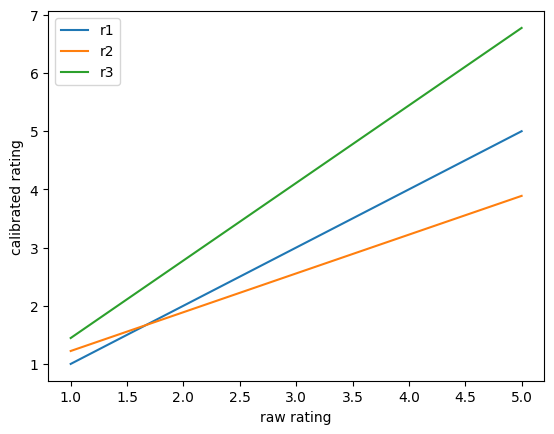

In [12]:
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('raw rating')
plt.ylabel('calibrated rating')
xs = [x/10. for x in range(10, 51)]
for r in ('r1', 'r2', 'r3'):
    plt.plot(xs, [cp.calibrate_rating(r, x) for x in xs], label=r)
plt.legend()
plt.show()

We see that when `r1` rates somebody e.g. 3 stars, it corresponds to 3 stars on the calibrated scale. Meanwhile, when `r2` rates somebody 3 stars, it corresponds to roughly 2.5 stars on the calibrated scale. Finally, when `r3` rates somebody 3 stars, it corresponds to roughly 4 stars on the calibrated scale. Let's analyze `r3`'s curve. The fact that `r3`'s curve is above the rest means that `r3` gives people lower raw ratings than `r1` and `r2` (indeed looking at the `data` dict, this is clear). Hence, when `r3` gives a raw rating, the calibration boosts it according to `r3`'s curve in the plot above.

The curves are given by the functions $y = a_r x + b_r$, where $y$ is the calibrated rating, $x$ is the raw rating, $a_r$ is the parameter given by `cp.reviewer_scale(r)`, and $b_r$ is the parameter given by `cp.reviewer_offset(r)`. Let's replot the above plot, but relabel the legend so we can see these parameters:

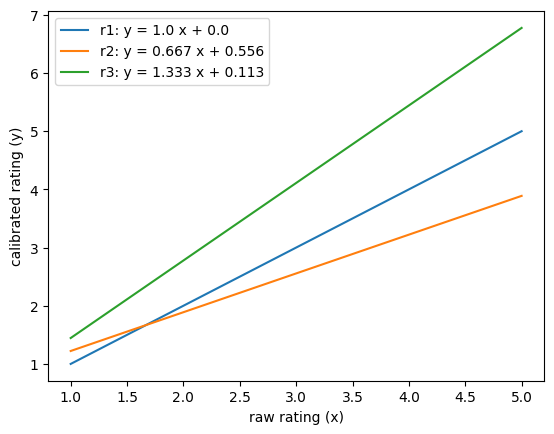

In [13]:
plt.figure()
plt.xlabel('raw rating (x)')
plt.ylabel('calibrated rating (y)')
for r in ('r1', 'r2', 'r3'):
    ar = round(cp.reviewer_scale(r), 3)
    br = round(cp.reviewer_offset(r), 3)
    plt.plot(
        xs, [cp.calibrate_rating(r, x) for x in xs], 
        label=f"{r}: y = {ar} x + {br}"
    )
plt.legend()
plt.show()

Notice that when `r3` rates somebody 5 stars, it corresponds to roughly 6.5 stars on the calibrated scale. This may seem nonintuitive at first, but in fact it makes a lot of sense. If you look at the original data dictionary `data`, you'll see that `r3`'s raw ratings are much lower than everybody else's, and indeed `r3` never rates anybody above 3 stars. Hence, already by a raw rating of 3.5 stars, `r3`'s calibrated rating has reached 5 stars. 

That being said, if you want the calibrated reviews to always lie between 1 and 5, you can set the optional argument `clip_endpoints` to `(1, 5)`.

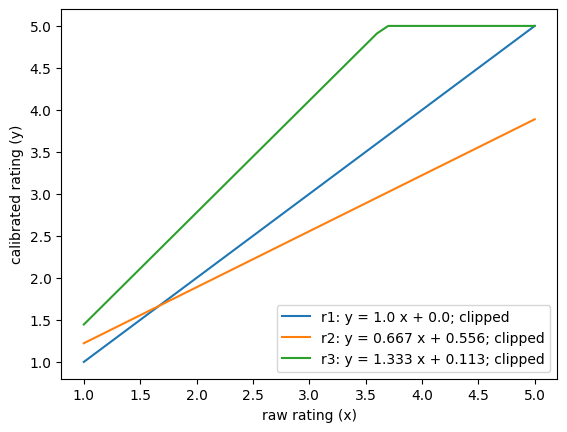

In [14]:
plt.figure()
plt.xlabel('raw rating (x)')
plt.ylabel('calibrated rating (y)')
for r in ('r1', 'r2', 'r3'):
    ar = round(cp.reviewer_scale(r), 3)
    br = round(cp.reviewer_offset(r), 3)
    plt.plot(
        xs, [cp.calibrate_rating(r, x, clip_endpoints=(1, 5)) for x in xs], 
        label=f"{r}: y = {ar} x + {br}; clipped"
    )
plt.legend()
plt.show()

## Performance functions

We now see the performance functions $g_p$ that were fit to the data. For each person $p$, the performace function $g_p(d)$ tells us the learned calibrated rating of that person on day $d$.

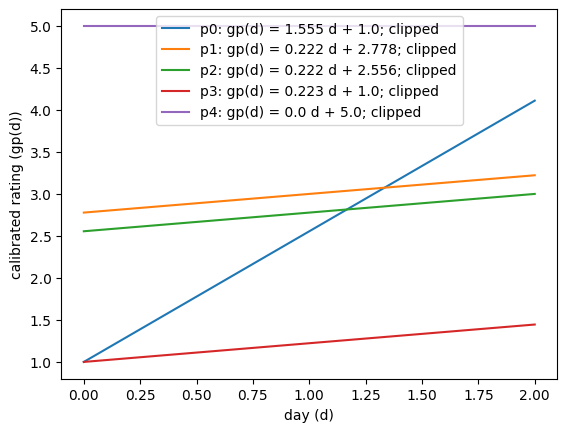

In [15]:
plt.figure()
ds = range(3)
plt.xlabel('day (d)')
plt.ylabel('calibrated rating (gp(d))')
for p in ('p0', 'p1', 'p2', 'p3', 'p4'):
    betap = round(cp.improvement_rate(p), 3)
    gammap = round(cp.person_offset(p), 3)
    plt.plot(
        ds, [cp.performance_function(p, d, clip_endpoints=(1, 5)) for d in ds], 
        label=f"{p}: gp(d) = {betap} d + {gammap}; clipped"
    )
plt.legend()
plt.show()

## Fast calibration

`rcal` is written in Python. However, it is written with a C extension so that the calibration is fast. Indeed, consider the following random example with 30,000 reviews.

In [16]:
import random, time

big_data = {}
for r in range(15):
    for p in range(200):
        for d in range(10):
            big_data[(r, p, d)] = random.random()
print("Number of reviews:", len(big_data))

Number of reviews: 30000


The calibration typically takes less than 2 seconds.

In [17]:
%timeit rcal.calibrate_parameters(big_data)

216 ms ± 16.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
